In [18]:
from ISLP import load_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from xgboost import XGBRegressor
import shap

In [2]:
d = load_data('Boston')

In [3]:
y = d['medv']
X = d[['lstat', 'age', 'rad', 'nox']]
X100 = X[100:200]

In [4]:
linear = LinearRegression()
linear.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
explainer = shap.Explainer(linear, X100)
shap_values = explainer(X.iloc[0:1])
shap_values, linear.predict(X.iloc[0:1])

(.values =
 array([[ 7.80921425, -0.73084402,  0.12905011,  0.23758952]])
 
 .base_values =
 array([22.99893087])
 
 .data =
 array([[ 4.98 , 65.2  ,  1.   ,  0.538]]),
 array([30.44394072]))

In [6]:
shap_values.values.sum() + shap_values.base_values

array([30.44394072])

In [7]:
X = d[['age', 'rad', 'tax', 'dis', 'rm', 'lstat', 'indus', 'chas']]
y = d['medv']
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64

In [8]:
rf = RandomForestRegressor(max_depth=6, random_state=0)
rf.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
X_train = X.iloc[:100].copy()
data_to_explain = X.iloc[470:471].copy()

In [10]:
explainer = shap.KernelExplainer(rf.predict, X_train)
k_shap_values = explainer.shap_values(data_to_explain)
phi0 = explainer.expected_value
phi0, k_shap_values

  0%|          | 0/1 [00:00<?, ?it/s]

(22.705866762121367,
 array([[-0.48369177,  0.05621368, -0.50234379,  0.10729553, -0.7118797 ,
         -3.4777253 , -0.03936596,  0.        ]]))

In [11]:
explainer = shap.KernelExplainer(rf.predict, shap.sample(X, 300))
k_shap_values = explainer.shap_values(data_to_explain)
phi0 = explainer.expected_value
phi0, k_shap_values

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

(22.111860209743753,
 array([[-0.31084012, -0.05574581, -0.46998539,  0.80570161, -1.23689135,
         -3.10051161, -0.07108827, -0.01812982]]))

In [12]:
explainer = shap.KernelExplainer(rf.predict, shap.kmeans(X, 100))
k_shap_values = explainer.shap_values(data_to_explain)
phi0 = explainer.expected_value
phi0, k_shap_values

  0%|          | 0/1 [00:00<?, ?it/s]

(21.864063860059613,
 array([[-0.27538643, -0.01939478, -0.5060313 ,  0.82304417, -0.88327099,
         -3.28415867, -0.0555015 , -0.00899491]]))

In [13]:
explainer = shap.Explainer(rf, X_train)
explainer(data_to_explain), explainer.expected_value

(.values =
 array([[-0.48420006,  0.05621368, -0.50180235,  0.10729552, -0.71243135,
         -3.47819316, -0.03936595,  0.        ]])
 
 .base_values =
 array([22.70586676])
 
 .data =
 array([[ 84.    ,  24.    , 666.    ,   3.0334,   6.167 ,  16.29  ,
          18.1   ,   0.    ]]),
 22.705866762121364)

In [14]:
explainer = shap.Explainer(rf)
explainer(data_to_explain), explainer.expected_value

(.values =
 array([[-0.01197207, -0.06930951, -0.43150206,  1.5089722 , -1.76366518,
         -4.01422248, -0.04678118, -0.03102378]])
 
 .base_values =
 array([22.51387352])
 
 .data =
 array([[ 84.    ,  24.    , 666.    ,   3.0334,   6.167 ,  16.29  ,
          18.1   ,   0.    ]]),
 array([22.51387352]))

In [16]:
X = d[['rm', 'age', 'crim', 'nox']]
y = d['medv']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 4), (102, 4), (404,), (102,))

In [45]:
model = XGBRegressor(max_depth=3, n_estimator=1000, eta=0.3, min_child_weight=20, reg_alpha=1)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9589500344309437, 0.6763330240581475)

In [46]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
interaction_values = explainer.shap_interaction_values(X_test)

In [47]:
expected = explainer.expected_value
expected, shap_values[0]

(22.612757,
 array([-2.3173664,  1.8279676,  1.5228661,  1.4299399], dtype=float32))

In [48]:
np.shape(interaction_values)

(102, 4, 4)

In [50]:
shap_values[0, 0] - sum(interaction_values[0, 0, 1:])

-2.1694433093070984

In [52]:
pd.DataFrame(interaction_values[0], index=X.columns, columns=X.columns)

,rm,age,crim,nox
rm,-2.169443,-0.269906,0.004978,0.117005
age,-0.269907,2.633449,-0.452107,-0.083467
crim,0.004977,-0.452107,1.697270,0.272726
nox,0.117005,-0.083468,0.272726,1.123676


In [58]:
y_pred = model.predict(X_test)
sum_shap = np.sum(interaction_values[0])
y_pred[0], expected + sum_shap

(25.076168, 25.076164)

In [63]:
mean_shap = np.abs(interaction_values).mean(0)
df = pd.DataFrame(mean_shap, index=X.columns, columns=X.columns)
df

,rm,age,crim,nox
rm,4.217321,0.270238,0.200908,0.314999
age,0.270238,1.749916,0.209188,0.178568
crim,0.200908,0.209188,1.253086,0.348889
nox,0.314999,0.178568,0.348889,1.914594


In [60]:
df = df.where(df.values == np.diagonal(df), df.values * 2)
df

,rm,age,crim,nox
rm,4.217321,0.540475,0.401816,0.629998
age,0.540475,1.749916,0.418375,0.357135
crim,0.401816,0.418375,1.253086,0.697777
nox,0.629998,0.357135,0.697777,1.914594


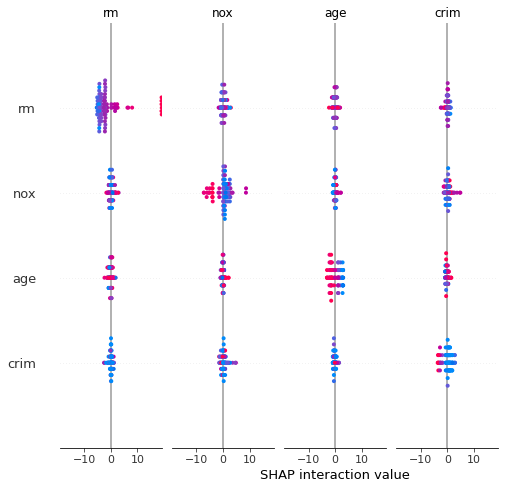

In [61]:
shap.summary_plot(interaction_values, X_test)

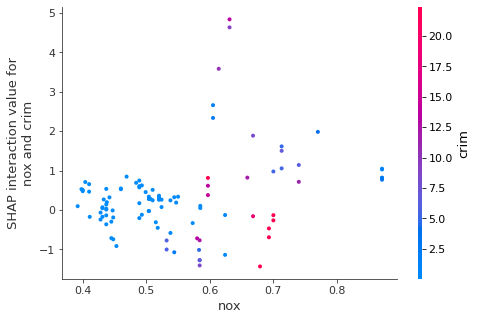

In [64]:
shap.dependence_plot(('nox', 'crim'), interaction_values, X_test, display_features=X)